In [1]:
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
from pydent import AqSession


def get_config(overrides=None, config_path='conf', config_name='config', override_with_docker_compose: str = 'docker-compose.yaml'):
    overrides = overrides or []
    
    with initialize(config_path=config_path):
        cfg = compose(config_name=config_name, overrides=overrides)

    # correct port from docker-compose file
    ports = cfg.docker.services.neo4j.ports
    port_mapping = {}
    for p in ports:
        _from, _to = p.split(':')
        port_mapping[_from] = _to
    cfg.neo.port = port_mapping['7687']
    return cfg

def aq_sess(cfg):
    return AqSession(cfg.aquarium.login, cfg.aquarium.password, cfg.aquarium.host)

def neo_driver(conf):
    return GraphDatabase.driver(conf.neo.host, auth=(conf.neo.user, conf.neo.password))
    
cfg = get_config()

aq = aq_sess(cfg)

print(OmegaConf.to_yaml(cfg))

aquarium:
  host: http://0.0.0.0
  login: vrana
  password: Mountain5
neo:
  host: bolt://localhost
  port: '7687'
  uri: ${neo.host}:${neo.port}
  user: neo4j
  password: redpill
docker:
  version: '2.0'
  services:
    neo4j:
      image: neo4j
      environment:
      - NEO4J_AUTH=neo4j/test
      ports:
      - 7474:7474
      - 7687:7687
      volumes:
      - $HOME/bin/neo4j/data:/data
      - $HOME/bin/neo4j/logs:/logs
      - $HOME/bin/neo4j/import:/var/lib/neo4j/import
      - $HOME/bin/neo4j/plugins:/plugins



/home/justin/anaconda3/envs/aqneoETL/lib/python3.8/site-packages/omegaconf/omegaconf.py:572: UserWarning: update() merge flag is is not specified, defaulting to False.
For more details, see https://github.com/omry/omegaconf/issues/367
  warnings.warn(


[(('Sample', 34562), {'attr_dict': {}}), (('Sample', 34563), {'attr_dict': {}}), (('Sample', 34561), {'attr_dict': {}}), (('Sample', 34560), {'attr_dict': {}}), (('Sample', 34559), {'attr_dict': {}}), (('Sample', 34556), {'attr_dict': {}}), (('Sample', 34557), {'attr_dict': {}}), (('Sample', 34558), {'attr_dict': {}}), (('Sample', 34554), {'attr_dict': {}}), (('Sample', 34555), {'attr_dict': {}}), (('Sample', 34551), {'attr_dict': {}}), (('Sample', 34552), {'attr_dict': {}}), (('Sample', 34553), {'attr_dict': {}}), (('Sample', 34549), {'attr_dict': {}}), (('Sample', 34550), {'attr_dict': {}}), (('Sample', 34548), {'attr_dict': {}}), (('Sample', 34546), {'attr_dict': {}}), (('Sample', 34547), {'attr_dict': {}}), (('Sample', 34544), {'attr_dict': {}}), (('Sample', 34545), {'attr_dict': {}}), (('Sample', 34541), {'attr_dict': {}}), (('Sample', 34542), {'attr_dict': {}}), (('Sample', 34543), {'attr_dict': {}}), (('Sample', 34539), {'attr_dict': {}}), (('Sample', 34540), {'attr_dict': {}}),

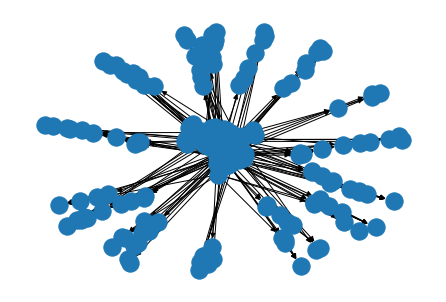

In [10]:
from pydent.base import ModelBase
from pydent.models import Sample, FieldValue, SampleType

def is_model(x):
    return issubclass(type(x), ModelBase)

def key_func(model):
    name = model.get_server_model_name()
    id = model.id
    
    return (name, id), model.dump()

TYPE = "type"
    
def get_models(model):
    if isinstance(model, Sample):
        for fv in model.field_values:
            yield fv, {TYPE: 'hasFieldValue'}
        
        yield model.sample_type, {TYPE: 'hasSampleType'}
    elif isinstance(model, FieldValue):
        if model.parent_class == 'Sample':
            parent = model.get_parent()
            field_type = parent.safe_get_field_type(model)
        else:
            field_type = model.field_type
        if field_type:
            yield field_type, {TYPE: 'hasFieldType'} 

            if field_type.ftype == 'sample' and model.sample:
                yield model.sample, {TYPE: 'hasSample'}
    elif isinstance(model, SampleType):
        for ft in model.field_types:
            yield ft, {TYPE: 'hasFieldType'}

def cache_func(models):
    session = models[0].session
    
    samples = [m for m in models if isinstance(m, Sample)]
    session.browser.get(samples, {
            'sample_type': {
                'field_types': []
            },
            'field_values': {
                'sample': {
                    'sample_type',
                },
                'allowable_field_type': {'sample_type', 'object_type'},
                'field_type': []
            }
        })
    
    
    field_values = [m for m in models if isinstance(m, FieldValue)]
    session.browser.get(field_values, {
        'field_type': {
            'allowable_field_types': {'sample_type', 'object_type'}
        },
        'allowable_field_type': {'sample_type', 'object_type'},
        'sample': {
            'sample_type',
            'field_values'
        }
    })

import networkx as nx
with aq.with_cache(timeout=120) as sess:
    g = sess.browser.relationship_network(aq.Sample.last(30), get_models=get_models, cache_func=cache_func, strict_cache=False) 
nx.draw(g)
print(g.nodes(data=True))

In [ ]:
aq.FieldValue.one().dump()

In [18]:
aq.Sample.one().dump()

{'updated_at': '2020-06-18T16:38:45.000-07:00',
 'row': None,
 'column': None,
 'parent_id': 284966,
 'parent_class': 'Operation',
 'child_item_id': 396661,
 'created_at': '2020-06-18T16:38:45.000-07:00',
 'allowable_field_type_id': 96,
 'child_sample_id': 30356,
 'id': 1052475,
 'rid': 2579,
 'field_type_id': 117,
 'name': 'Plate',
 'value': None,
 'role': 'input',
 'sid': '30356: pPINK_pUBQ10::at_mNeonGreen::tUBQ1',
 'child_sample_name': '30356: pPINK_pUBQ10::at_mNeonGreen::tUBQ1'}

In [4]:
aq.Sample.one().dump()

{'updated_at': '2020-06-18T16:37:30.000-07:00',
 'project': 'trident',
 'description': '973c1bd1-9bee-4427-a0c9-bd5d9ce76657',
 'sample_type_id': 5,
 'created_at': '2020-06-18T16:37:19.000-07:00',
 'data': None,
 'id': 34562,
 'rid': 1652,
 'name': 'mynewsampleb1556bd7-4b10-48b0-b253-7652de61f2b8',
 'user_id': 66}

In [207]:
fv = aq.FieldValue.find(89470)
print(fv.name)
for ft in fv.get_parent().sample_type.field_types:
    print(ft.name)

Sequencing_primer_ids
Sequence
Sequence Verification
Bacterial Marker
Yeast Marker
Length
Sequencing Primers
QC Primer1
QC Primer2
QC_length
Transformation Temperature
Comp Cells


In [194]:
fv.get_parent().get_safe_field_type

AttributeError: 'Sample' object has no attribute 'get_safe_field_type'

In [195]:
sample.safe_get_field_type

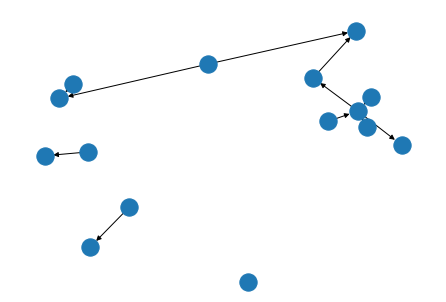

[(('Sample', 34562), {'attr_dict': {}}), (('Sample', 34563), {'attr_dict': {}}), (('Sample', 34561), {'attr_dict': {}}), (('Sample', 34560), {'attr_dict': {}}), (('Sample', 34559), {'attr_dict': {}}), (('Sample', 34556), {'attr_dict': {}}), (('Sample', 34557), {'attr_dict': {}}), (('Sample', 34558), {'attr_dict': {}}), (('Sample', 34554), {'attr_dict': {}}), (('Sample', 34555), {'attr_dict': {}}), (('Sample', 34454), {'attr_dict': {}}), (('Sample', 9246), {'attr_dict': {}}), (('Sample', 1092), {'attr_dict': {}}), (('Sample', 4243), {'attr_dict': {}}), (('Sample', 3109), {'attr_dict': {}})]
[34562, 34563, 34561, 34560, 34559, 34556, 34557, 34558, 34554, 34555, 34454, 9246, 1092, 4243, 3109]


In [ ]:
import networkx as nx

with aq.with_cache(timeout=120) as sess:
    g = sess.browser.sample_network(aq.Sample.last(10))
    nx.draw(g)

    prop_cache_query =  {
        'sample_type': {
            'field_types': []
        },
        'field_values': {
            'sample': {'sample_type',},
            'allowable_field_type': {'sample_type', 'object_type'},
            'field_type': []
        }
    }

    print(g.nodes(data=True))
    sample_ids = [n[1] for n in g.nodes()]
    print(sample_ids)

In [112]:
sample = aq.Sample.one()

dir(sample.fields['sample_type'])

['ACCESSOR',
 'QUERY_TYPE',
 'SELF',
 '_Callback__FLAGS',
 '_FIELD_ALLOW_NONE_DEFAULT',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_callback_signature',
 '_deserialize',
 '_get_ref_attr',
 '_serialize',
 'allow_none',
 'always_dump',
 'attr',
 'build_query',
 'cache',
 'cache_result',
 'callback',
 'callback_args',
 'callback_kwargs',
 'data_key',
 'default',
 'deserialize',
 'fullfill',
 'get_callback_args',
 'get_callback_kwargs',
 'get_ref',
 'many',
 'nested',
 'nested_field',
 'objtype',
 'ref',
 'register',
 'serialize',
 'set_data_key']

In [31]:
from neo4j import GraphDatabase
from neo4j.exceptions import ClientError
import re
from .query import format_cypher_query


class AquariumETL:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        try:
            self.setup()
        except ClientError:
            pass

    def close(self):
        self.driver.close()

    def setup(self):
        with self.driver.session() as session:
            session.run("CREATE CONSTRAINT primary_key "
                        "ON (sample:Sample) ASSERT sample.id IS UNIQUE")

    def create_constraint(self, model):
        with self.driver.session() as sess:
            sess.run()  # "CREATE CONSTRAIN {}_primary_key ".format(model.get_tableized_name())
            # "ON (m:{n} ASSERT m.{id} is UNIQUE".format(n=model.get_server_model_name(), 'id'))

    def clear(self):
        with self.driver.session() as sess:
            query = """
            MATCH (a) -[r]-> () DELETE a, r;
            MATCH (a) DELETE a
            """
            sess.run(query)

    def update(self, model, mode="MATCH"):
        with self.driver.session() as session:
            node_label = model.get_server_model_name()
            data = model.dump()
            return session.write_transaction(self._create, node_label, data, mode=mode)

    def create(self, model):
        return self.update(model, mode='CREATE')

    @staticmethod
    def _create(tx, node_label, data, mode="CREATE"):
        query = format_cypher_query("""
        {mode} (n:{node_label})
        SET n.{key} = ${key}
        RETURN n
        """, mode=mode, node_label=node_label, key=list(data))
        result = tx.run(query, **data)
        return result.single()[0]
        format_cypher_query()
    #     def where(self, query, on_return=None):
    #         if on_return is None:
    #             def on_return(result):
    #                 return result.values()
    #         with self.driver.session() as session:
    #             query_str = ', '.join(["{k}: ${k}".format(k=k, v=v) for k, v in query.items()])
    #             query_str = "{{ {} }}".format(query_str)
    #             q = "MATCH (n {})".format(query_str)
    #             return on_return(session.run("MATCH (n {id: $id, id: $id}) RETURN n", **query))

    @staticmethod
    def process_query(query, **kwargs):
        found_keys = set()
        for k in re.findall("\$(\w+)", query):
            print(kwargs)
            if k in kwargs:
                print(k)
                query = re.sub("\${}".format(k), str(kwargs[k]), query)
                found_keys.add(k)

        return query, found_keys

    @classmethod
    def _create_tx(cls, query, process, **kwargs):
        query, used_keys = cls.process_query(query, **kwargs)
        remaining_keys = set(kwargs).difference(used_keys)
        remaining_kwargs = {k: kwargs[k] for k in remaining_keys}

        def transaction(tx):
            result = tx.run(query, **remaining_kwargs)
            return process(result)

        return transaction

    def write(self, query, **kwargs):
        with self.driver.session() as session:
            tx = self._create_tx(query, process=lambda x: x.values(), **kwargs)
            return session.write_transaction(tx)

    def read(self, query, **kwargs):
        with self.driver.session() as session:
            tx = self._create_tx(query, process=lambda x: x.values(), **kwargs)
            return session.read_transaction(tx)


<Sample id=34562 name=mynewsampleb1556bd7-4b10-48b0-b253-7652de61f2b8 sample_type=None rid=150>
<Sample id=34563 name=mynewsampleb1556bd7-4b10-48b0-b253-7652de61f2b8|B06228357bddf-5cc2-4a35-bd9c-b810a0def5d7 sample_type=None rid=151>
<Sample id=34561 name=mynewsampled5579ff3-04d7-42c1-96ca-507997c389f3 sample_type=None rid=152>
<Sample id=34560 name=74e5be4b-da71-4ff7-be20-c4104e121a20 sample_type=None rid=153>
<Sample id=34559 name=215e4658-9ab5-4d5f-8473-94f2dd9937d8 sample_type=None rid=154>
<Sample id=34556 name=mynewsamplead3d8fe5-a017-4ca3-8380-38da36fcd7e8 sample_type=None rid=155>
<Sample id=34557 name=mynewsamplec4c301d9-2903-4702-9d82-c31c9b8f7fb0 sample_type=None rid=156>
<Sample id=34558 name=mynewsamplead3d8fe5-a017-4ca3-8380-38da36fcd7e8|B0622553d7e41-0c60-47f6-8232-f2fa4f24c567 sample_type=None rid=157>
<Sample id=34554 name=d85fe093-7752-4053-b03b-90d00560f3d4 sample_type=None rid=158>
<Sample id=34555 name=566fe2a5-e8d8-492c-9a4e-c7d05478882e sample_type=None rid=159>


[[<Node id=6 labels=frozenset({'Sample'}) properties={'sample_type_id': 1, 'updated_at': '2020-06-18T16:37:02.000-07:00', 'user_id': 66, 'name': '215e4658-9ab5-4d5f-8473-94f2dd9937d8', 'description': '', 'created_at': '2020-06-18T16:37:02.000-07:00', 'project': 'test', 'id': 34559, 'rid': 154}>],
 [<Node id=7 labels=frozenset({'Sample'}) properties={'sample_type_id': 5, 'updated_at': '2020-06-12T09:47:21.000-07:00', 'user_id': 66, 'name': 'mynewsamplead3d8fe5-a017-4ca3-8380-38da36fcd7e8', 'description': 'b51eed7c-3077-48bc-bb66-0b4baf2e6777', 'created_at': '2020-06-12T09:47:10.000-07:00', 'project': 'trident', 'id': 34556, 'rid': 155}>],
 [<Node id=8 labels=frozenset({'Sample'}) properties={'sample_type_id': 5, 'updated_at': '2020-06-12T09:47:10.000-07:00', 'user_id': 66, 'name': 'mynewsamplec4c301d9-2903-4702-9d82-c31c9b8f7fb0', 'created_at': '2020-06-12T09:47:10.000-07:00', 'project': 'trident', 'id': 34557, 'rid': 156}>],
 [<Node id=9 labels=frozenset({'Sample'}) properties={'sample

In [106]:
def _lengths(*args):
    length = None
    idxs = []
    for arg in args:
        if isinstance(arg, list) or isinstance(arg, tuple):
            if length is None:
                length = len(arg)
            elif len(arg) != length:
                raise ValueException
            idxs.append(length)
        else:
            idxs.append(0)
    return idxs

_lengths(1, 2, 3, [2, 3, 4], [4, 5, 3])

[0, 0, 0, 3, 3]

In [100]:


query = """
{mode} (n:{label})
SET n.{key[1]} = ${key[0]}
RETURN n
"""

def _iter_zip(*args):
    iter_arr = []
    arr = []
    iter_arr_idx = []
    arr_idx = []
    for i, a in enumerate(args):
        if isinstance(a, list) or isinstance(a, tuple):
            iter_arr.append(a)
            iter_arr_idx.append(i)
        else:
            arr.append(a)
            arr_idx.append(i)
            
    lengths = [len(x) for x in iter_arr]
    if len(set(lengths)) > 1:
        raise ValueError("Iterables provided must be exactly same length. Found " + str(lengths))
    
    if lengths:
        expected_lengths = lengths[0]
    else:
        expected_lengths = 1
        
    expanded_arr = [[a]*expected_lengths for a in arr]
    yield from zip(*iter_arr, *expanded_arr)
    
    

kwargs = {"key": ['mykey', 'otherkey'], 'mode': 'CREATE', 'label': 'label'}
formatted_lines = []
pattern = re.compile("{\s*(\w+)\s*}")
for line in query.splitlines():
    formatted = line
    
    keys = list()
    for match in pattern.finditer(line):
        key = match.group(1)
        if key in kwargs and key not in keys:
            keys.add(key)
    vals = [kwargs[k] for k in keys]
    for key, val in 
        
    
    
            
    
#         val = kwargs[key]
#         if not isinstance(val, list):
#             val = [val]
#         for _val in val:
#             formatted = re.sub(match.group(0), _val, formatted)
#     formatted_lines.append(formatted.strip())

# print('\n'.join(formatted_lines))
    
#     for key in keys:
#         if key in kwargs:
#             val = kwargs[key]
#             re.sub()

# def query_format(query, **kwargs):
#     formatted_lines = []
#     for line in query.splitlines():
#         if line.strip():
            

set()
{'label', 'mode'}
{'key'}
set()


In [96]:
def _iter_zip(*args):
    iter_arr = []
    arr = []
    for a in args:
        if isinstance(a, list) or isinstance(a, tuple):
            iter_arr.append(a)
        else:
            arr.append(a)
    lengths = [len(x) for x in iter_arr]
    if len(set(lengths)) > 1:
        raise ValueError("Iterables provided must be exactly same length. Found " + str(lengths))
    
    if lengths:
        expected_lengths = lengths[0]
    else:
        expected_lengths = 1
        
    expanded_arr = [[a]*expected_lengths for a in arr]
    yield from zip(*iter_arr, *expanded_arr)
    
list(_iter_zip(1, 2, [1, 2, 3], [3, 2, 5]))
    

[(1, 3, 1, 2), (2, 2, 1, 2), (3, 5, 1, 2)]

In [59]:
match.group(1)

'key'

In [188]:
q = "MATCH (n) RETURN n"
with etl.driver.session() as session:
    values = session.run(q).values()

print(values)

[[<Node id=3 labels=frozenset({'Sample'}) properties={'sample_type_id': 5, 'updated_at': '2020-06-18T16:37:30.000-07:00', 'user_id': 66, 'name': 'mynewsampleb1556bd7-4b10-48b0-b253-7652de61f2b8', 'description': '973c1bd1-9bee-4427-a0c9-bd5d9ce76657', 'created_at': '2020-06-18T16:37:19.000-07:00', 'project': 'trident', 'id': 34562, 'rid': 73}>], [<Node id=4 labels=frozenset({'Sample'}) properties={'sample_type_id': 5, 'updated_at': '2020-06-18T16:37:19.000-07:00', 'user_id': 66, 'name': 'mynewsampleb1556bd7-4b10-48b0-b253-7652de61f2b8|B06228357bddf-5cc2-4a35-bd9c-b810a0def5d7', 'created_at': '2020-06-18T16:37:19.000-07:00', 'project': 'trident', 'id': 34563, 'rid': 74}>], [<Node id=5 labels=frozenset({'Sample'}) properties={'sample_type_id': 5, 'updated_at': '2020-06-18T16:37:18.000-07:00', 'user_id': 66, 'name': 'mynewsampled5579ff3-04d7-42c1-96ca-507997c389f3', 'created_at': '2020-06-18T16:37:18.000-07:00', 'project': 'trident', 'id': 34561, 'rid': 75}>], [<Node id=6 labels=frozenset(

In [10]:
import re

def process_query(query, **kwargs):
    found_keys = set()
    for k in re.findall("\$(\w+)", query):
        if k in kwargs:
            query = re.sub("\${}".format(k), str(kwargs[k]), query)
            found_keys.add(k)
    return query, found_keys


def _create_tx(query, **kwargs):
    query, used_keys = self.process_query(query, **kwargs)
    remaining_keys = set(kwargs).difference(used_keys)
    remaining_kwargs = {k: kwargs[k] for k in remaining_keys}
    def transaction(tx):
        result, tx.run(query, **remaining_kwargs)
    return transaction

def write(query, **kwargs):
    with self.driver.session() as session:
        return session.write_transaction(_create_tx(query))
# def _create_transaction(query, **kwargs):
#     query, used_keys = self.process_query(query, **kwargs)
#     def transaction(tx, **kwargs):
#         result = tx.run()


# def write(query, **kwargs):
#     query, used_keys = self._find_and_replace(query, **kwargs)
#     remaining_keys = set(kwargs).difference(used_keys)
#     def transaction(tx, **kwargs):
#         result = tx.run()
        
#     with self.driver.session() as session:
#         return session.read_transaction(transaction, **kwargs)
    

    
s = "MATCH (n:$label) { id: $id }"
process_query(s, label='mylabel')

('MATCH (n:mylabel) { id: $id }', {'label'})

In [163]:
re.findall("\$(\w+)", s)

['label', 'id']

In [155]:
# with etl.driver.session() as session:
#     def foo(tx):
#         result = tx.run("MATCH (n) RETURN n")
#         return result.values()
#     result = session.read_transaction(foo)

# results

NameError: name 'results' is not defined

In [127]:
result

In [104]:
import re


def find_format_keys(s):
    return re.findall("{\s*(\w+)\s*}", s)

def create_transaction(query, kwargs):
    keys = find_format_keys(query)
    other_keys = set(kwargs).difference(set(keys))
    formatted_query = query.format(**kwargs)
    remaining_kwargs = {k: kwargs[k] for k in other_keys}
    
    def _tx(tx, **kwargs):
        result = tx.run(formatted_query, **kwargs)
    print(formatted_query)
    print(keys)
    print(other_keys)
    print(remaining_kwargs)
    
create_transaction("MATCH (n:{label} {{ id: $id }}) RETURN n", dict(label='SAMPLE'))

MATCH (n:SAMPLE { id: $id }) RETURN n
['label']
set()
{}


In [34]:
with etl.driver.session() as session:
    def find(tx):
        return tx.run("MATCH (n) RETURN n")
    session.write_transaction(find)
    
etl.find(1, 2)()()

In [ ]:
etl.driver.session().write_transaction

In [24]:
model = session.Sample.one()

etl.update(model)

<Node id=0 labels=frozenset({'Sample'}) properties={'sample_type_id': 5, 'updated_at': '2020-06-18T16:37:30.000-07:00', 'user_id': 66, 'name': 'mynewsampleb1556bd7-4b10-48b0-b253-7652de61f2b8', 'description': '973c1bd1-9bee-4427-a0c9-bd5d9ce76657', 'created_at': '2020-06-18T16:37:19.000-07:00', 'project': 'trident', 'id': 34562, 'rid': 12}>